In [249]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy.optimize import minimize

import pandas as pd


In [241]:
# in the data directory, find all files that include Lightcurve-DEFAULT in their name   
import glob
files = glob.glob('../data/*/*Lightcurve-DEFAULT*.fits')
files

['../data/CHEOPS-products-20240319122713/CH_PR240004_TG000102_TU2024-03-16T06-03-23_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
 '../data/CHEOPS-products-20240311145359/CH_PR240004_TG000101_TU2024-03-09T05-11-42_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
 '../data/CHEOPS-products-20240312075007/CH_PR240017_TG000801_TU2024-03-11T08-38-42_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
 '../data/CHEOPS-products-20240325102059/CH_PR240004_TG000103_TU2024-03-23T04-05-22_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
 '../data/CHEOPS-products-20240322074703/CH_PR240017_TG000901_TU2024-03-21T03-05-43_SCI_COR_Lightcurve-DEFAULT_V0300.fits']

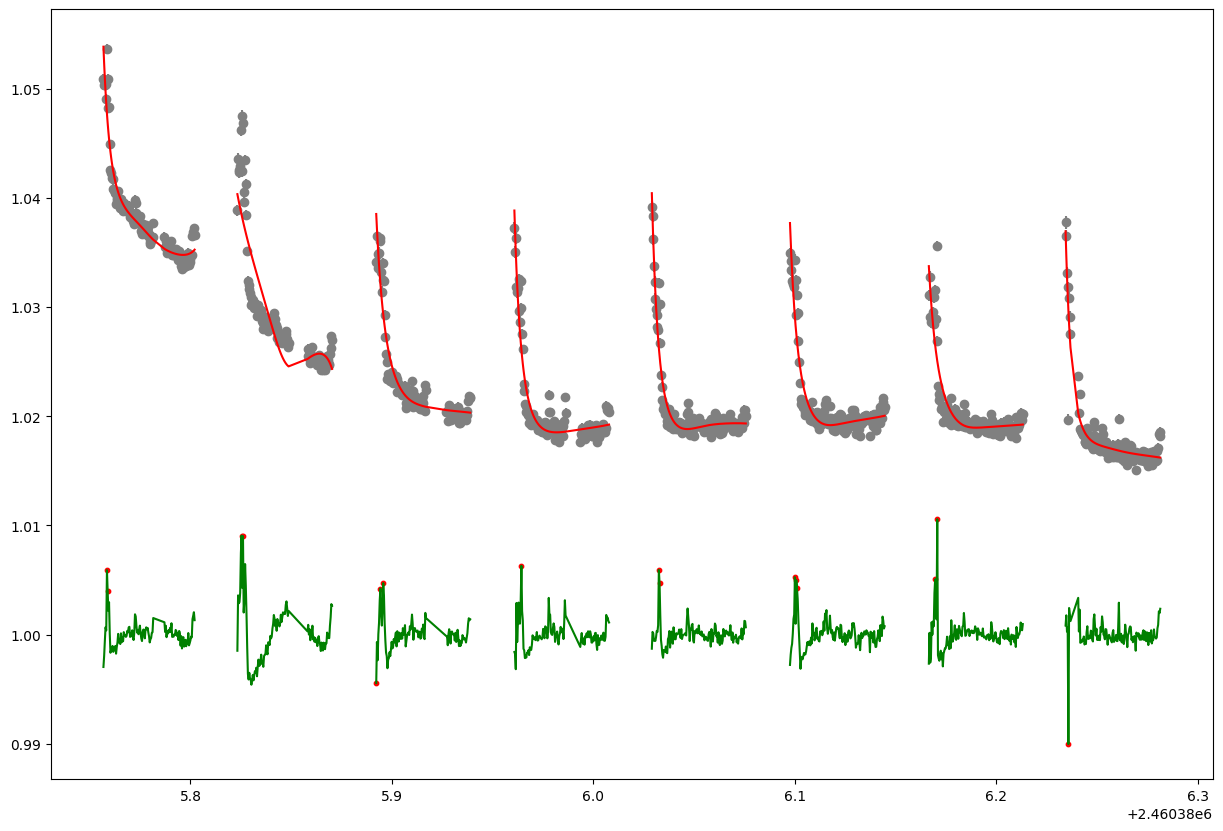

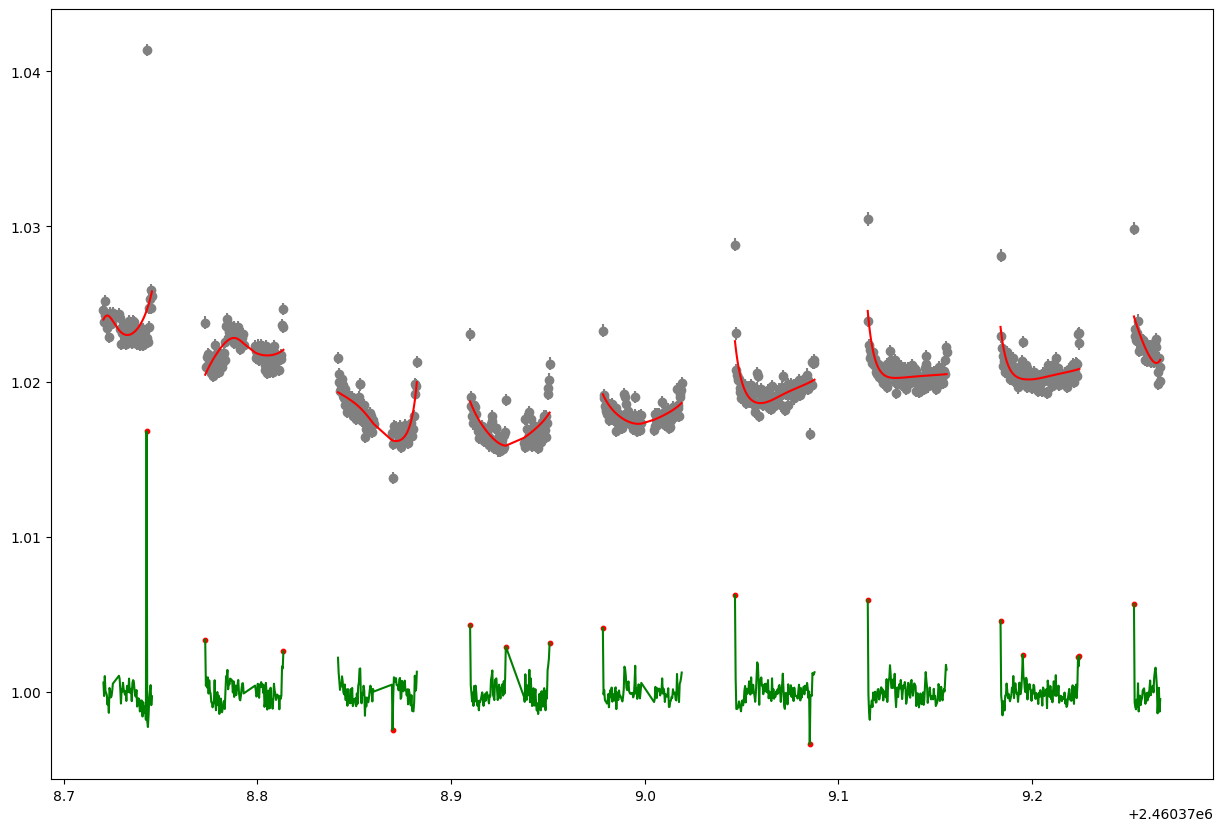

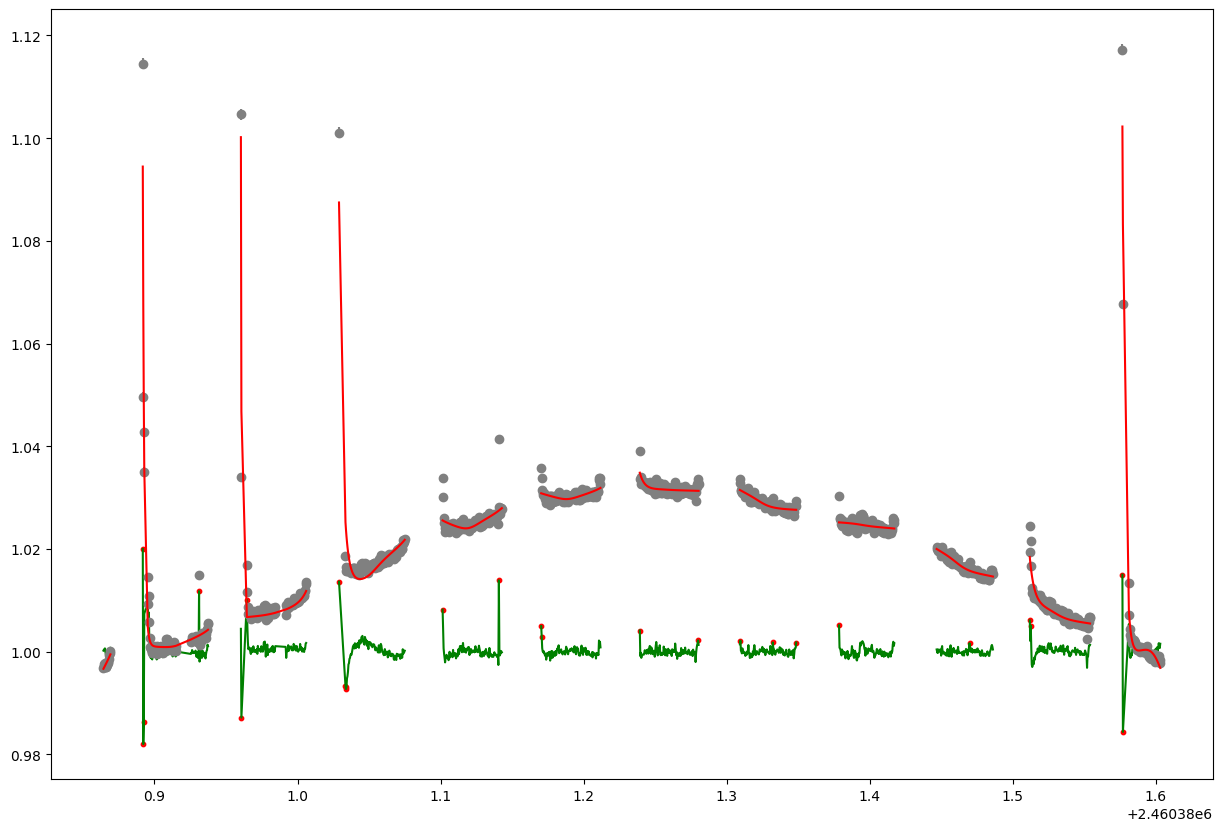

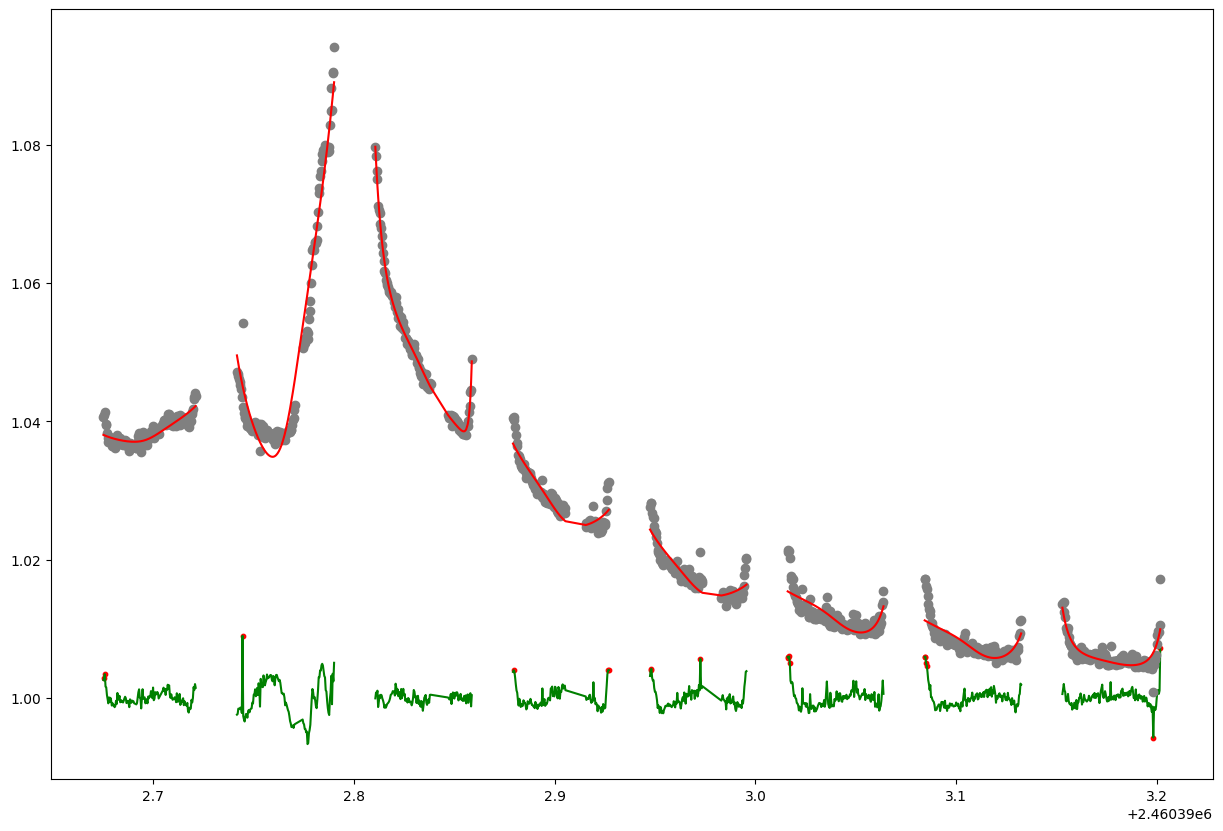

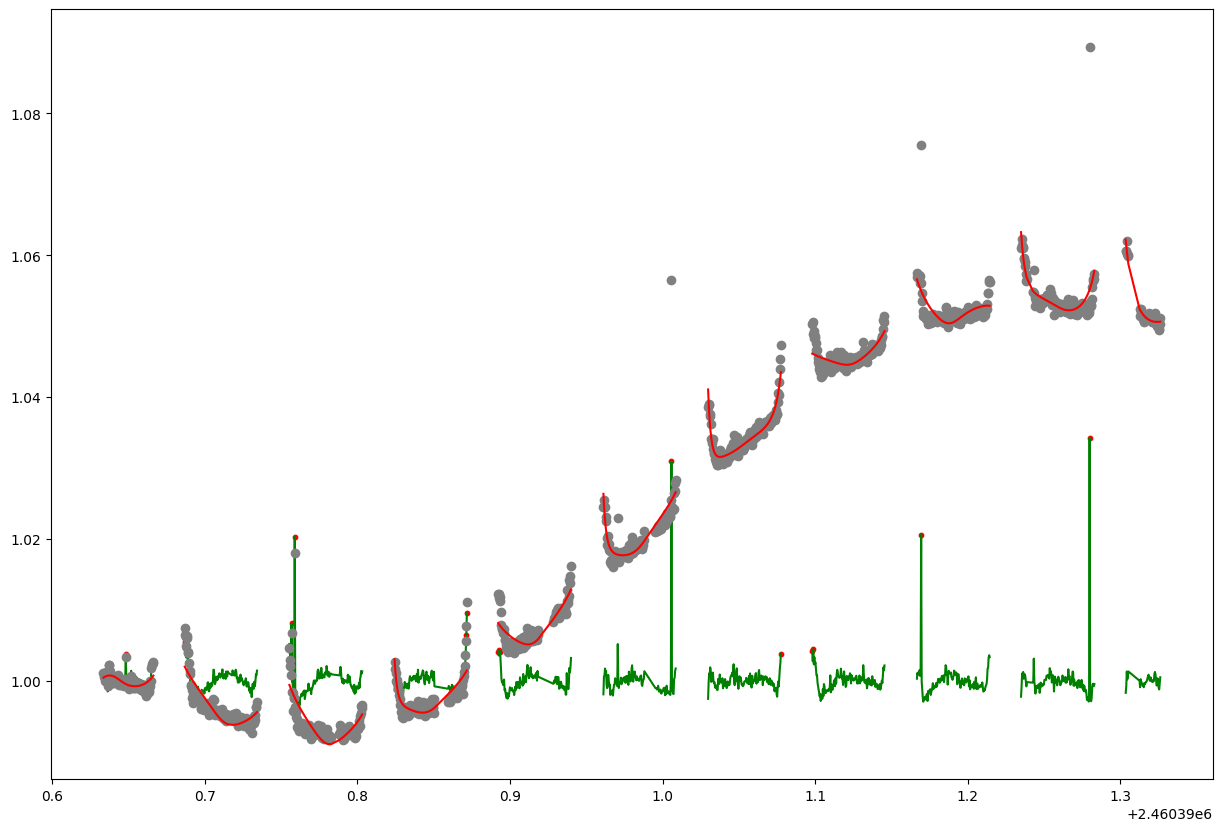

In [285]:

bigf = []
bigt = []
bigferr = []
bigmodel = []
bigroll = []
bigindex = []
bigchunk = []   
bigdata = []

for file in files:


    # open the cor data
    cor = fits.open(file)

    # print(cor[1].header.values)
    t, f, ferr, s, roll = cor[1].data['BJD_TIME'], cor[1].data['FLUX'], cor[1].data['FLUXERR'], cor[1].data['STATUS'], cor[1].data['ROLL_ANGLE']
    # normalize the flux and flux error
    med = np.median(f)
    fn = f / med
    ferrn = ferr / med

    # select only s==0 data
    t, fn, ferrn, roll = t[s==0], fn[s==0], ferrn[s==0], roll[s==0]

    # clip outliers over 8 sigma
    idx = np.abs(fn - np.median(fn)) < 5 * np.std(fn)
    t, fn, ferrn, roll = t[idx], fn[idx], ferrn[idx], roll[idx]



    # split the light curve into chunks where the roll angle diff is negative
    roll_diff = np.diff(roll)

    # find indices where the roll angle difference is positive
    split_idx = np.where(roll_diff > 0)[0] + 1


    # split the light curve into chunks
    f_chunks = np.split(fn / np.median(fn), split_idx)
    t_chunks = np.split(t, split_idx)
    ferr_chunks = np.split(ferrn  / np.median(fn) , split_idx)
    roll_chunks = np.split(roll / 180 * np.pi, split_idx)  #radians

    plt.figure(figsize=(15, 10))


    # plot the chunks
    for i in range(len(f_chunks)):
        plt.errorbar(t_chunks[i], f_chunks[i] + 0.02, yerr=ferr_chunks[i], fmt='o', c="grey")

        # fit an exponential function to each chunk
        def model(x, a, b, c, d , m,n,f, o, g):
            return a * np.exp(b * (x - d)) + c + n * np.exp(m*(x-f)) + o * (x-g) 
 
        # fit model with minimize
        p = minimize(lambda p: np.sum((model(roll_chunks[i], *p) - f_chunks[i])**2), [.01, 1.3, 1., 3.7, 0.001, 2., 0.1, -1, 2.]).x

        # plot the fit
        plt.plot(t_chunks[i], model(roll_chunks[i], *p) + 0.02 , c='r', zorder=20)

        # plot the residuals
        plt.plot(t_chunks[i], f_chunks[i] -model(roll_chunks[i], *p)  +1. , c='g')

        # mark 3 sigma outliers in residuals
        residuals = f_chunks[i] - model(roll_chunks[i], *p)
        idx = np.abs(residuals - np.median(residuals)) > 3 * np.std(residuals)
        plt.scatter(t_chunks[i][idx], residuals[idx] +1, c='r', s=10)


        # append the fit to the big arrays
        bigmodel.append(model(roll_chunks[i], *p))
        bigf.append(residuals+1.)
        bigt.append(t_chunks[i])
        bigferr.append(ferr_chunks[i])
        bigroll.append(roll_chunks[i])
        ident = file.split('CHEOPS-products-')[1][:8]

        bigindex.append(np.full(len(t_chunks[i]), ident))
        bigchunk.append(np.full(len(t_chunks[i]), i))
        bigdata.append(f_chunks[i])

    # make pandas data frame

df = pd.DataFrame({'t': np.concatenate(bigt),
                    'f': np.concatenate(bigf), 
                    'ferr': np.concatenate(bigferr), 
                    'model': np.concatenate(bigmodel),
                    'roll': np.concatenate(bigroll),
                    'lindex': np.concatenate(bigindex),
                    'chunk': np.concatenate(bigchunk),
                    'data': np.concatenate(bigdata)})

df = df.sort_values('t')


    # plt.scatter(t, roll, c='r', s=10)

    # plt.ylim(.99, 1.04)
    # plt.xlim(0,1.)



20240311
20240312
20240319
20240322
20240325


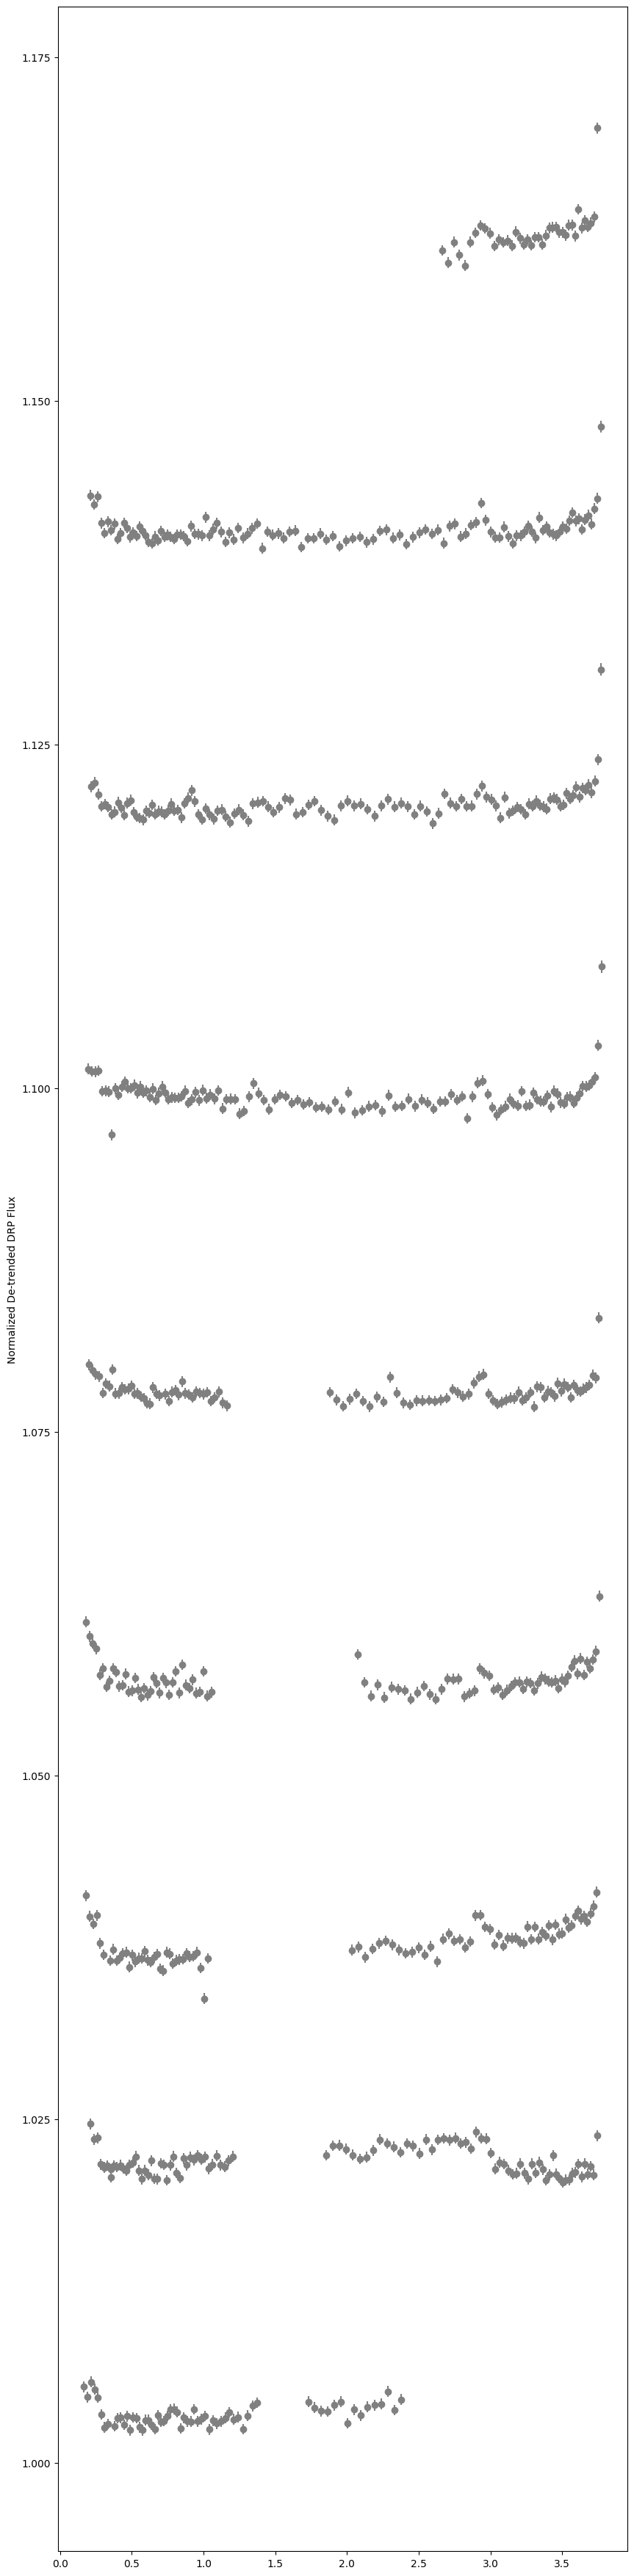

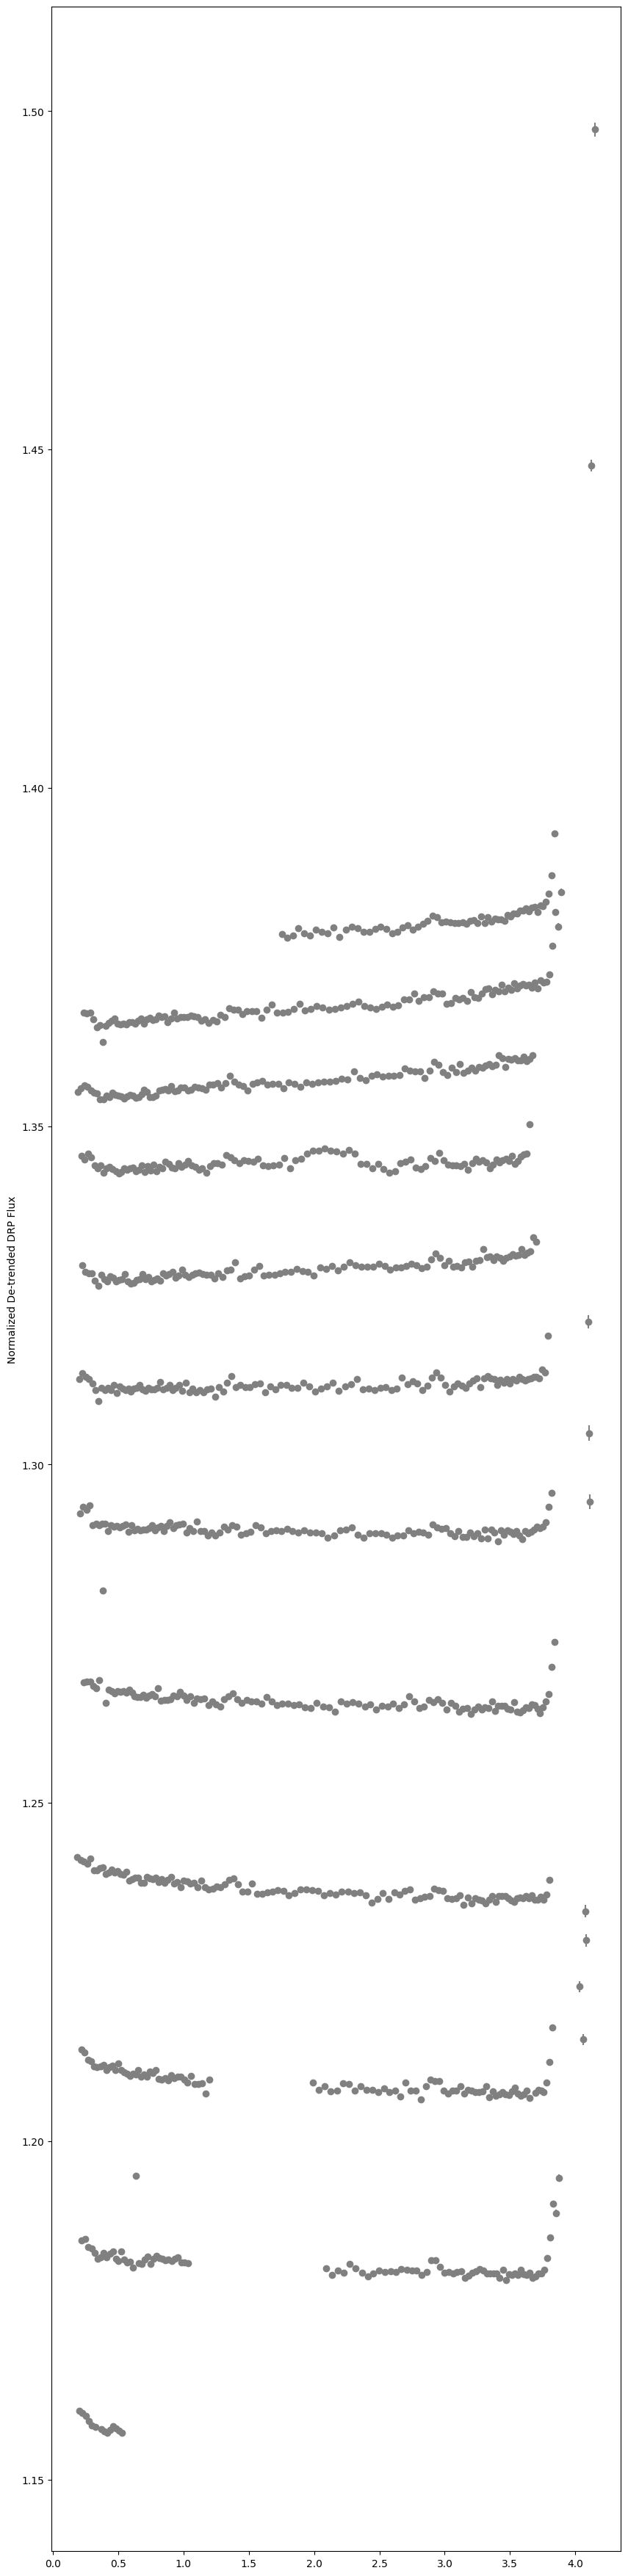

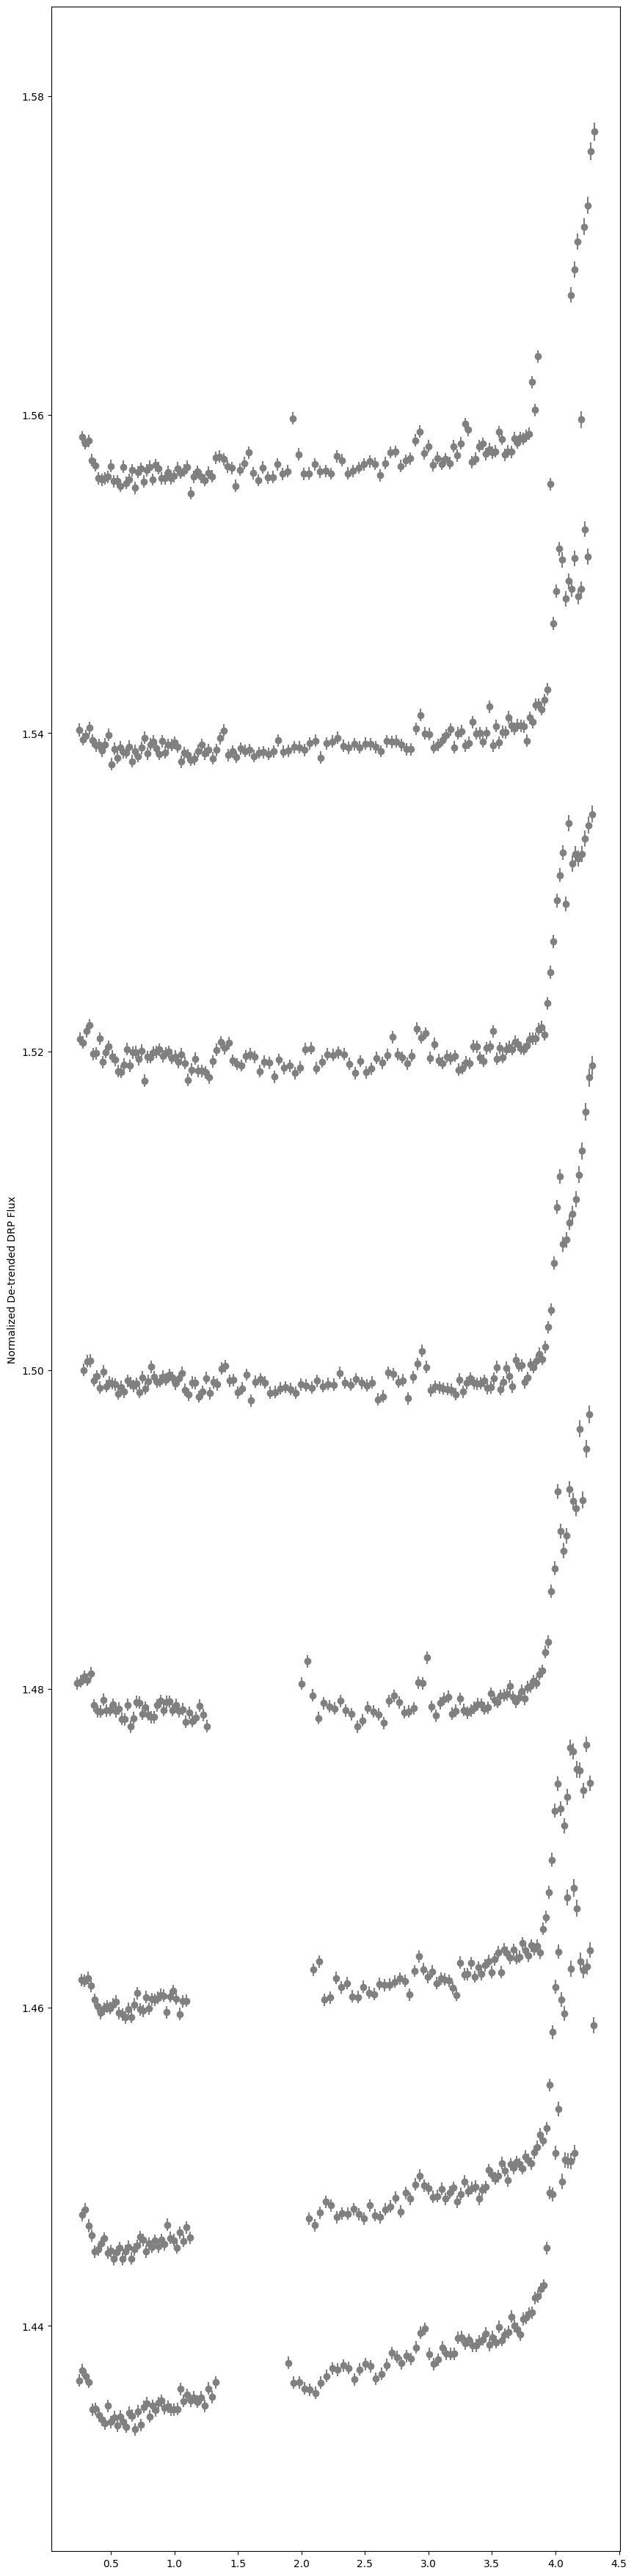

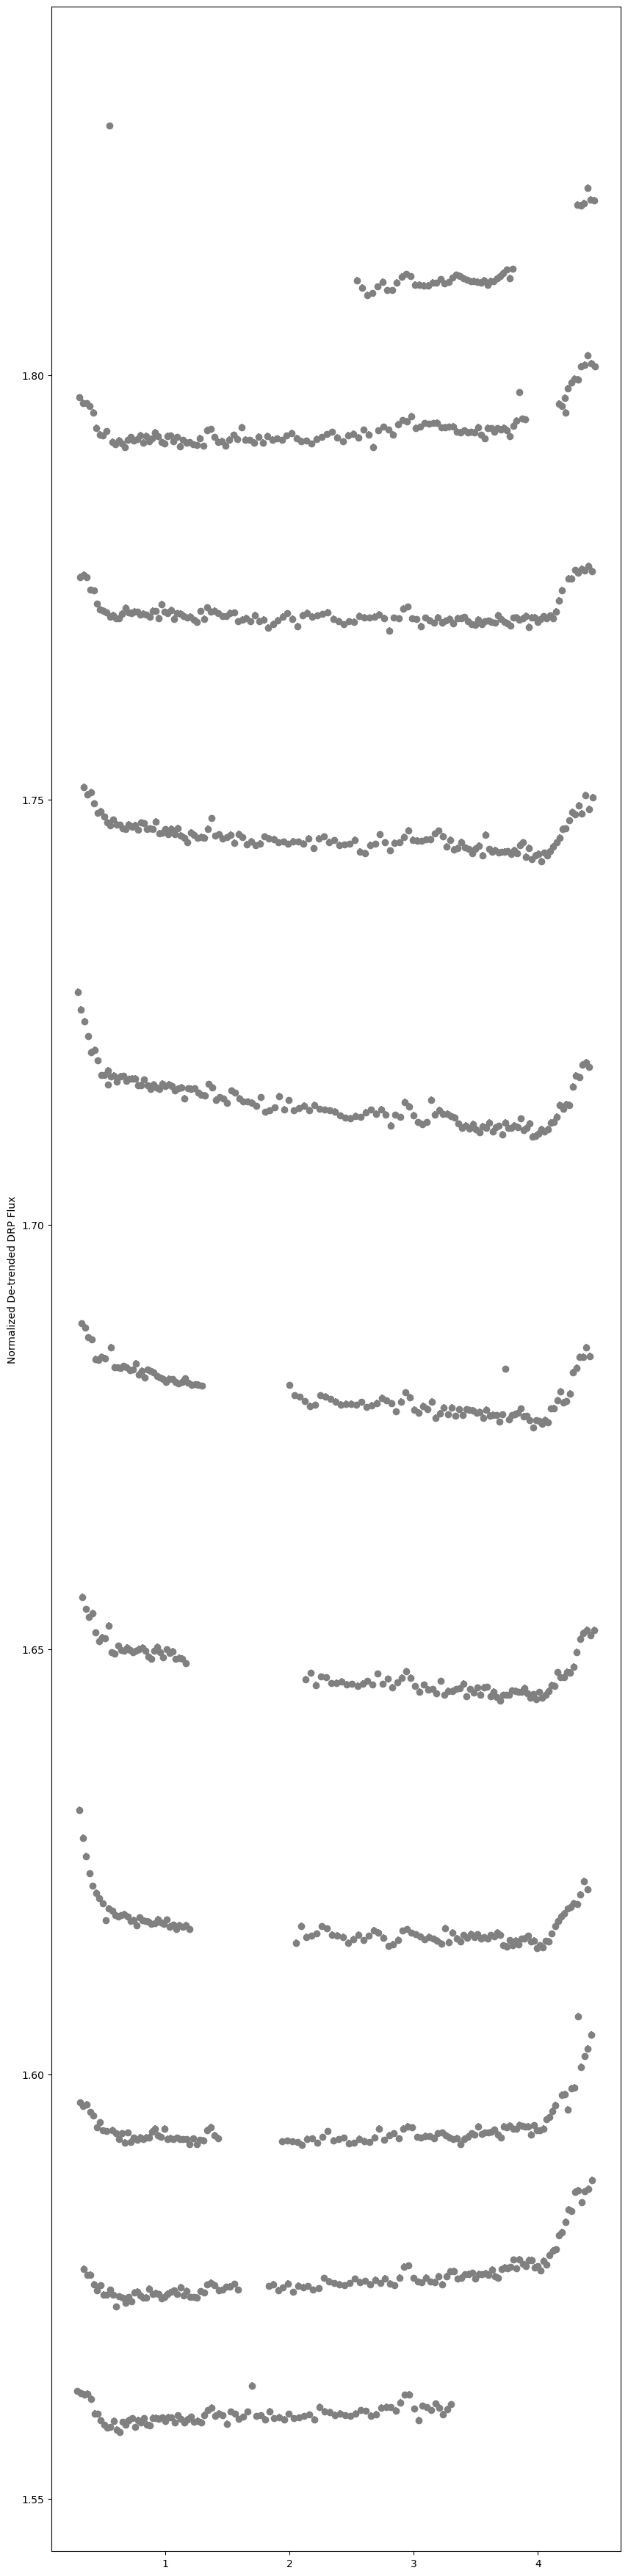

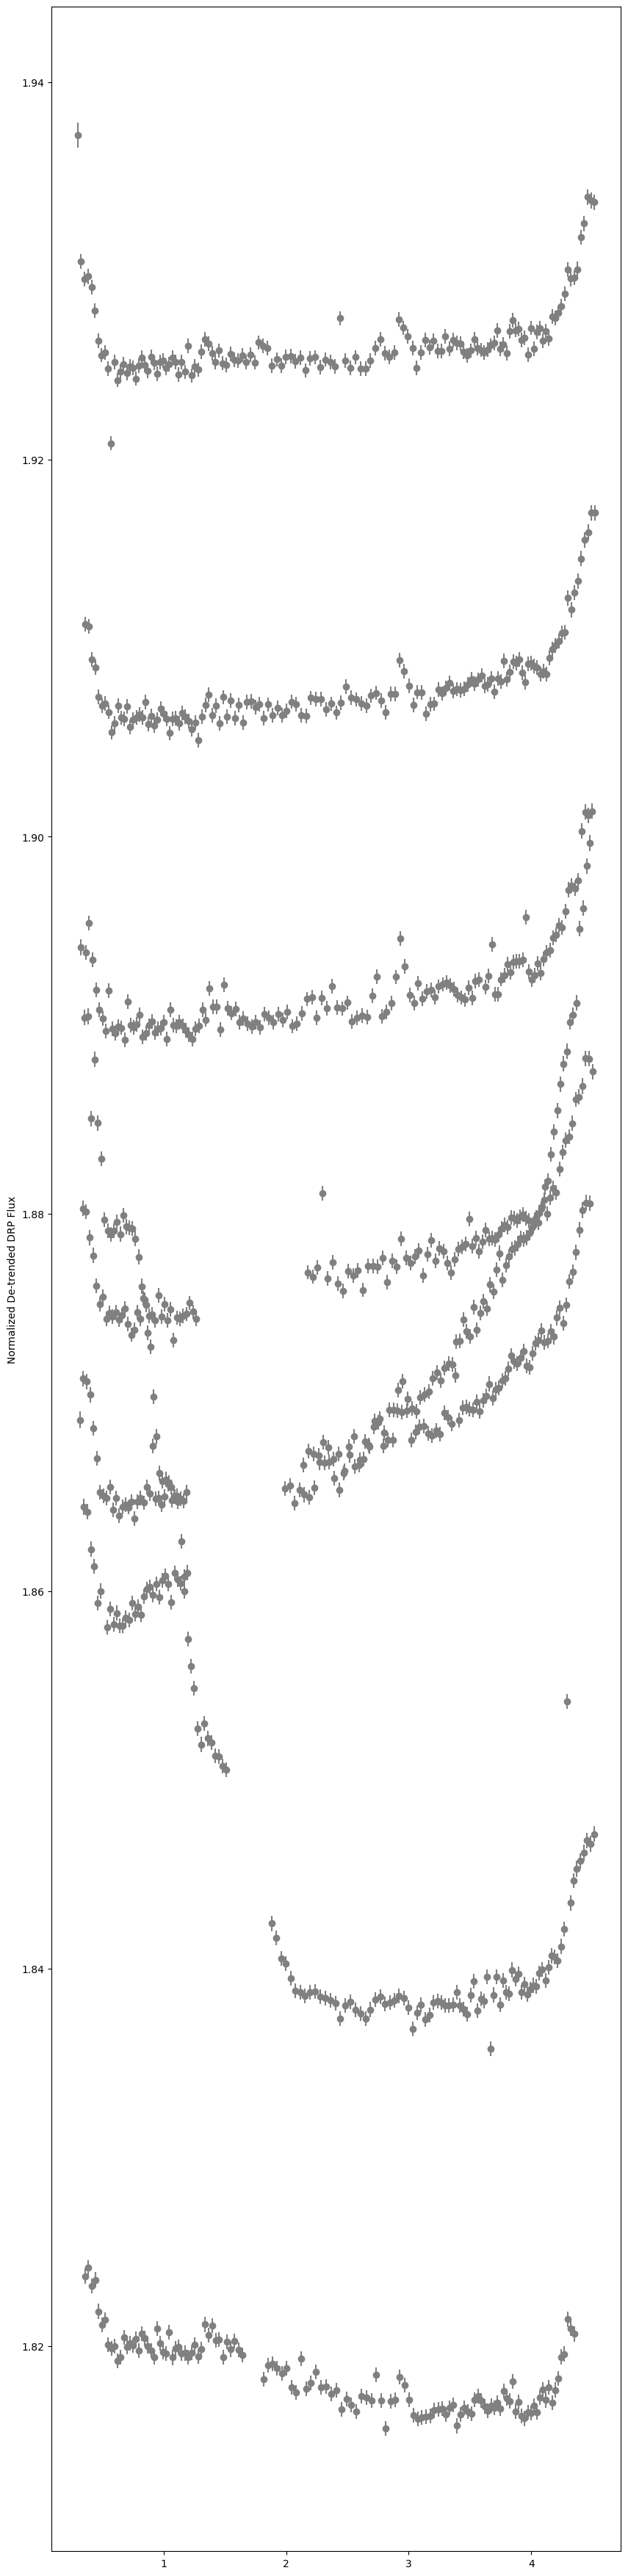

In [286]:

off = 0
for l, g in df.groupby('lindex'):
    print(l)
    plt.figure(figsize=(10, 45))
    for m, h in g.groupby('chunk'):
        plt.errorbar(h['roll'], h['data'] +off, yerr=h['ferr'], fmt='o', c="grey")
        off += 0.02

# for transit_time in [2460378.69698,2460385.65648,2460392.61598]:
#     plt.axvline(transit_time, c='r')    

# plt.xlabel('Time [BJD]')
    plt.ylabel('Normalized De-trended DRP Flux')    